# Feature Engineering Worksheet
## Transforming Raw Data into Powerful Features

Feature engineering is often considered the key to successful machine learning. In this workshop, you'll learn:

1. **Feature Scaling & Normalization**
2. **Polynomial & Interaction Features** 
3. **Categorical Encoding Techniques**
4. **Feature Selection Methods**
5. **Creating Features from DateTime & Text**
6. **Real-world Examples & Best Practices**

**"Raw data is like a diamond in the rough - feature engineering is the art of cutting and polishing it."**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression, load_wine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, 
    PolynomialFeatures, LabelEncoder, OneHotEncoder
)
from sklearn.feature_selection import (
    SelectKBest, f_regression, mutual_info_regression,
    RFE, SelectFromModel
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
np.random.seed(42)

## 1. Feature Scaling and Normalization

Different algorithms are sensitive to feature scales. Let's explore various scaling techniques.

Original Data Statistics:
               age         salary   experience       rating
count  1000.000000    1000.000000  1000.000000  1000.000000
mean     35.193321   67109.217275     8.023337     3.763811
std       9.792159   16826.138803     3.933817     1.216350
min       2.587327   15339.756892    -4.078049     0.843625
25%      28.524097   56186.248794     5.408002     2.811940
50%      35.253006   67247.697102     7.998997     3.742973
75%      41.479439   78310.994469    10.643661     4.705572
max      73.527315  119243.337427    23.704951     6.578282


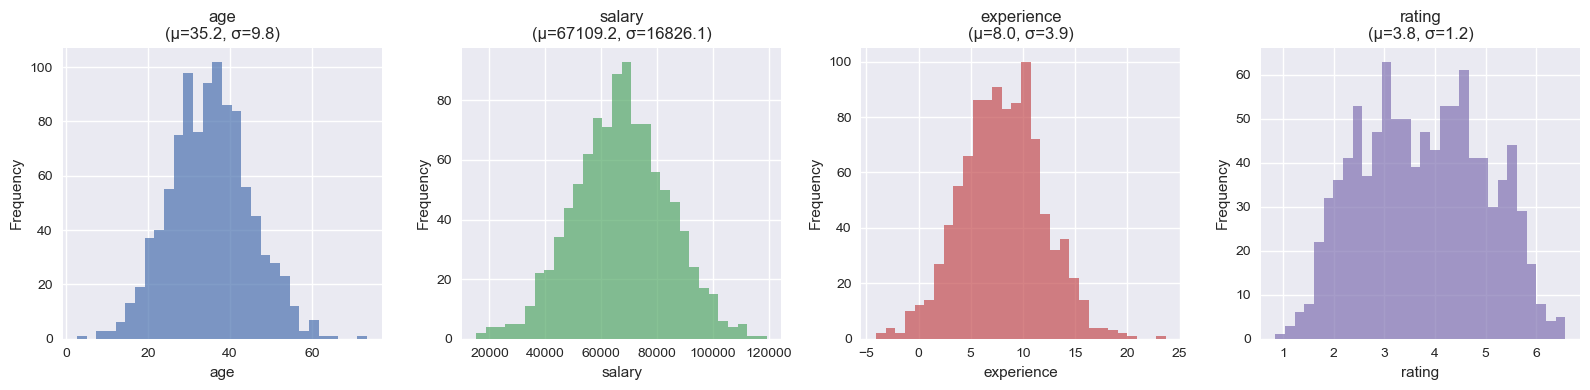

In [5]:
# Create sample data with different scales
np.random.seed(42)
n_samples = 1000

data = {
    'age': np.random.normal(35, 10, n_samples),  # 20-50 range
    'salary': np.random.normal(50000, 15000, n_samples),  # 20k-80k range
    'experience': np.random.normal(8, 4, n_samples),  # 0-16 range
    'rating': np.random.uniform(1, 5, n_samples)  # 1-5 range
}

# Add some correlation
data['salary'] += data['experience'] * 2000
data['rating'] += data['experience'] * 0.1

df_original = pd.DataFrame(data)

# Display basic statistics
print("Original Data Statistics:")
print(df_original.describe())

# Visualize the original distributions
plt.figure(figsize=(16, 4))

for i, col in enumerate(df_original.columns):
    plt.subplot(1, 4, i+1)
    plt.hist(df_original[col], bins=30, alpha=0.7, color=f'C{i}')
    plt.title(f'{col}\n(μ={df_original[col].mean():.1f}, σ={df_original[col].std():.1f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Different Scaling Techniques

In [ ]:
# Apply different scaling techniques
scalers = {
    'StandardScaler': StandardScaler(),  # (X - mean) / std
    'MinMaxScaler': MinMaxScaler(),      # (X - min) / (max - min)
    'RobustScaler': RobustScaler()       # (X - median) / IQR
}

scaled_data = {}
for name, scaler in scalers.items():
    scaled_data[name] = pd.DataFrame(
        scaler.fit_transform(df_original), 
        columns=df_original.columns
    )

# Visualize scaling effects
fig, axes = plt.subplots(4, 4, figsize=(16, 12))

datasets = {'Original': df_original, **scaled_data}

for row, (dataset_name, df) in enumerate(datasets.items()):
    for col, column in enumerate(df.columns):
        ax = axes[row, col]
        ax.hist(df[column], bins=30, alpha=0.7, color=f'C{col}')
        ax.set_title(f'{dataset_name}: {column}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Compare statistics
print("\nScaling Comparison (means and stds):")
for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"Means: {df.mean().round(3).values}")
    print(f"Stds:  {df.std().round(3).values}")

### Impact of Scaling on Model Performance

In [ ]:
# Create a simple regression problem
X, y = make_regression(n_samples=1000, n_features=4, noise=0.1, random_state=42)

# Make features have different scales
X[:, 0] *= 100      # Large scale
X[:, 1] *= 0.01     # Small scale
X[:, 2] *= 10       # Medium scale
# X[:, 3] stays as is

feature_names = ['Large_Scale', 'Small_Scale', 'Medium_Scale', 'Normal_Scale']
X_df = pd.DataFrame(X, columns=feature_names)

print("Feature Scales:")
print(X_df.describe())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Test different models with and without scaling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'SVR': SVR(kernel='rbf')
}

results = []

for model_name, model in models.items():
    # Without scaling
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2_no_scaling = r2_score(y_test, y_pred)
    
    # With standard scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train_scaled, y_train)
    y_pred_scaled = model.predict(X_test_scaled)
    r2_with_scaling = r2_score(y_test, y_pred_scaled)
    
    results.append({
        'Model': model_name,
        'R² (No Scaling)': r2_no_scaling,
        'R² (With Scaling)': r2_with_scaling,
        'Improvement': r2_with_scaling - r2_no_scaling
    })

results_df = pd.DataFrame(results)
print("\nScaling Impact on Model Performance:")
print(results_df.round(4))

## 2. Polynomial and Interaction Features

Creating non-linear features from linear ones can dramatically improve model performance.

In [ ]:
# Create a non-linear relationship
np.random.seed(42)
X_simple = np.random.uniform(-2, 2, (300, 2))
y_nonlinear = (
    X_simple[:, 0]**2 + 
    X_simple[:, 1]**2 + 
    X_simple[:, 0] * X_simple[:, 1] + 
    np.random.normal(0, 0.1, 300)
)

# Create DataFrame
df_poly = pd.DataFrame(X_simple, columns=['x1', 'x2'])
df_poly['y'] = y_nonlinear

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_simple, y_nonlinear, test_size=0.3, random_state=42
)

# Visualize the relationship
fig = plt.figure(figsize=(15, 5))

# 3D plot
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(df_poly['x1'], df_poly['x2'], df_poly['y'], c=df_poly['y'], cmap='viridis')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('y')
ax1.set_title('Original Non-linear Relationship')

# 2D projections
plt.subplot(132)
plt.scatter(df_poly['x1'], df_poly['y'], alpha=0.6, c='blue')
plt.xlabel('x1')
plt.ylabel('y')
plt.title('y vs x1')

plt.subplot(133)
plt.scatter(df_poly['x2'], df_poly['y'], alpha=0.6, c='red')
plt.xlabel('x2')
plt.ylabel('y')
plt.title('y vs x2')

plt.tight_layout()
plt.show()

### Comparing Linear vs Polynomial Features

In [ ]:
# Compare linear vs polynomial regression
degrees = [1, 2, 3, 4]
poly_results = []

plt.figure(figsize=(16, 10))

for i, degree in enumerate(degrees):
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train_poly)
    y_pred_test = model.predict(X_test_poly)
    
    # Calculate scores
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    poly_results.append({
        'Degree': degree,
        'Features': X_train_poly.shape[1],
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Overfitting': train_r2 - test_r2
    })
    
    # Create visualization mesh for degree 2
    if degree == 2:
        # Create mesh for prediction surface
        x1_range = np.linspace(X_simple[:, 0].min(), X_simple[:, 0].max(), 50)
        x2_range = np.linspace(X_simple[:, 1].min(), X_simple[:, 1].max(), 50)
        X1_mesh, X2_mesh = np.meshgrid(x1_range, x2_range)
        X_mesh = np.c_[X1_mesh.ravel(), X2_mesh.ravel()]
        X_mesh_poly = poly.transform(X_mesh)
        y_mesh_pred = model.predict(X_mesh_poly).reshape(X1_mesh.shape)
    
    # Plot results
    plt.subplot(2, 4, i+1)
    plt.scatter(y_test, y_pred_test, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Degree {degree}\nTest R² = {test_r2:.3f}')
    
    # Show feature names for degree 2
    if degree == 2:
        feature_names = poly.get_feature_names_out(['x1', 'x2'])
        plt.subplot(2, 4, i+5)
        coef_importance = np.abs(model.coef_)
        plt.bar(range(len(coef_importance)), coef_importance)
        plt.xticks(range(len(feature_names)), feature_names, rotation=45)
        plt.ylabel('Coefficient Magnitude')
        plt.title('Feature Importance (Degree 2)')
        
        print(f"\nDegree {degree} Features: {feature_names}")
        print(f"Coefficients: {model.coef_.round(3)}")

# Plot prediction surface for degree 2
if 'y_mesh_pred' in locals():
    plt.subplot(2, 4, 7)
    contour = plt.contourf(X1_mesh, X2_mesh, y_mesh_pred, levels=20, alpha=0.8, cmap='viridis')
    plt.scatter(X_simple[:, 0], X_simple[:, 1], c=y_nonlinear, cmap='viridis', edgecolors='black')
    plt.colorbar(contour)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Degree 2 Prediction Surface')

# Performance comparison
plt.subplot(2, 4, 8)
degrees_list = [r['Degree'] for r in poly_results]
train_r2s = [r['Train R²'] for r in poly_results]
test_r2s = [r['Test R²'] for r in poly_results]

plt.plot(degrees_list, train_r2s, 'o-', label='Train R²', linewidth=2)
plt.plot(degrees_list, test_r2s, 's-', label='Test R²', linewidth=2)
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('Train vs Test Performance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Results table
poly_df = pd.DataFrame(poly_results)
print("\nPolynomial Degree Comparison:")
print(poly_df.round(4))

## 3. Categorical Encoding Techniques

Machine learning models work with numbers, so we need to convert categorical variables appropriately.

In [ ]:
# Create sample categorical data
np.random.seed(42)
n_samples = 1000

categorical_data = {
    'city': np.random.choice(['NYC', 'LA', 'Chicago', 'Houston', 'Phoenix'], n_samples),
    'education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], n_samples, 
                                p=[0.4, 0.3, 0.2, 0.1]),
    'color': np.random.choice(['Red', 'Green', 'Blue'], n_samples),
    'size': np.random.choice(['Small', 'Medium', 'Large'], n_samples, p=[0.3, 0.5, 0.2])
}

# Create target variable with some relationship to categories
city_effect = {'NYC': 10, 'LA': 8, 'Chicago': 6, 'Houston': 5, 'Phoenix': 4}
education_effect = {'High School': 0, 'Bachelor': 5, 'Master': 8, 'PhD': 12}
size_effect = {'Small': -2, 'Medium': 0, 'Large': 3}

y_categorical = (
    [city_effect[city] for city in categorical_data['city']] +
    [education_effect[edu] for edu in categorical_data['education']] +
    [size_effect[size] for size in categorical_data['size']] +
    np.random.normal(0, 2, n_samples)
)

df_categorical = pd.DataFrame(categorical_data)
df_categorical['target'] = y_categorical

print("Categorical Data Sample:")
print(df_categorical.head(10))

# Visualize categorical distributions
plt.figure(figsize=(16, 8))

categorical_cols = ['city', 'education', 'color', 'size']
for i, col in enumerate(categorical_cols):
    plt.subplot(2, 4, i+1)
    df_categorical[col].value_counts().plot(kind='bar')
    plt.title(f'{col.title()} Distribution')
    plt.xticks(rotation=45)
    
    # Box plot showing relationship with target
    plt.subplot(2, 4, i+5)
    df_categorical.boxplot(column='target', by=col, ax=plt.gca())
    plt.title(f'Target vs {col.title()}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Different Encoding Techniques

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder, BinaryEncoder

# Prepare data
X_cat = df_categorical[categorical_cols]
y_cat = df_categorical['target']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_cat, y_cat, test_size=0.3, random_state=42
)

# Different encoding techniques
encoders = {
    'Label Encoding': LabelEncoder(),
    'One-Hot Encoding': OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
    'Ordinal Encoding': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Target Encoding': TargetEncoder(),
}

encoding_results = []

print("Encoding Comparison:")
print("=" * 50)

for encoding_name, encoder in encoders.items():
    print(f"\n{encoding_name}:")
    
    if encoding_name == 'Label Encoding':
        # Label encoding for each column separately
        X_train_encoded = X_train_cat.copy()
        X_test_encoded = X_test_cat.copy()
        
        for col in categorical_cols:
            le = LabelEncoder()
            X_train_encoded[col] = le.fit_transform(X_train_cat[col])
            # Handle unknown categories in test set
            X_test_encoded[col] = X_test_cat[col].map(
                dict(zip(le.classes_, le.transform(le.classes_)))
            ).fillna(-1).astype(int)
            
            print(f"  {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    
    elif encoding_name == 'Target Encoding':
        X_train_encoded = encoder.fit_transform(X_train_cat, y_train_cat)
        X_test_encoded = encoder.transform(X_test_cat)
        print(f"  Features created: {X_train_encoded.shape[1]}")
    
    else:
        X_train_encoded = encoder.fit_transform(X_train_cat)
        X_test_encoded = encoder.transform(X_test_cat)
        
        if encoding_name == 'One-Hot Encoding':
            feature_names = encoder.get_feature_names_out(categorical_cols)
            print(f"  Features created: {len(feature_names)}")
            print(f"  Sample features: {feature_names[:10]}...")
        else:
            print(f"  Features created: {X_train_encoded.shape[1]}")
    
    # Train a simple model to compare performance
    model = LinearRegression()
    model.fit(X_train_encoded, y_train_cat)
    
    y_pred = model.predict(X_test_encoded)
    r2 = r2_score(y_test_cat, y_pred)
    mse = mean_squared_error(y_test_cat, y_pred)
    
    encoding_results.append({
        'Encoding': encoding_name,
        'Features': X_train_encoded.shape[1],
        'R²': r2,
        'MSE': mse
    })
    
    print(f"  R² Score: {r2:.4f}")
    print(f"  MSE: {mse:.4f}")

# Results comparison
encoding_df = pd.DataFrame(encoding_results)
print("\n\nEncoding Performance Comparison:")
print(encoding_df.round(4))

### Visualizing Encoding Effects

In [ ]:
# Visualize different encoding effects for education column
plt.figure(figsize=(16, 10))

# Original relationship
plt.subplot(2, 3, 1)
education_means = df_categorical.groupby('education')['target'].mean().sort_values()
education_means.plot(kind='bar')
plt.title('Original: Education vs Target')
plt.xticks(rotation=45)
plt.ylabel('Average Target')

# Label Encoding
le_education = LabelEncoder()
education_labels = le_education.fit_transform(df_categorical['education'])
plt.subplot(2, 3, 2)
plt.scatter(education_labels, df_categorical['target'], alpha=0.5)
plt.xlabel('Label Encoded Education')
plt.ylabel('Target')
plt.title('Label Encoding')
education_mapping = dict(zip(le_education.classes_, le_education.transform(le_education.classes_)))
plt.xticks(list(education_mapping.values()), list(education_mapping.keys()), rotation=45)

# One-Hot Encoding visualization
ohe_education = OneHotEncoder(sparse_output=False)
education_onehot = ohe_education.fit_transform(df_categorical[['education']])
education_features = ohe_education.get_feature_names_out(['education'])

plt.subplot(2, 3, 3)
correlations = []
for i, feature in enumerate(education_features):
    corr = np.corrcoef(education_onehot[:, i], df_categorical['target'])[0, 1]
    correlations.append(corr)

plt.bar(range(len(education_features)), correlations)
plt.xticks(range(len(education_features)), 
           [f.replace('education_', '') for f in education_features], rotation=45)
plt.ylabel('Correlation with Target')
plt.title('One-Hot: Feature Correlations')

# Target Encoding
target_encoder = TargetEncoder()
education_target_encoded = target_encoder.fit_transform(
    df_categorical[['education']], df_categorical['target']
)
plt.subplot(2, 3, 4)
plt.scatter(education_target_encoded['education'], df_categorical['target'], alpha=0.5)
plt.xlabel('Target Encoded Education')
plt.ylabel('Target')
plt.title('Target Encoding')

# Feature count comparison
plt.subplot(2, 3, 5)
feature_counts = [1, 1, len(education_features), 1]  # Original, Label, One-Hot, Target
encoding_names = ['Original', 'Label', 'One-Hot', 'Target']
plt.bar(encoding_names, feature_counts)
plt.ylabel('Number of Features')
plt.title('Feature Count by Encoding')

# Performance comparison
plt.subplot(2, 3, 6)
r2_scores = [result['R²'] for result in encoding_results]
encoding_labels = [result['Encoding'] for result in encoding_results]
plt.bar(range(len(r2_scores)), r2_scores)
plt.xticks(range(len(encoding_labels)), encoding_labels, rotation=45)
plt.ylabel('R² Score')
plt.title('Model Performance by Encoding')

plt.tight_layout()
plt.show()

## 4. Feature Selection Techniques

Not all features are useful. Let's learn how to select the most important ones.

In [ ]:
# Create a dataset with many features, some relevant, some not
from sklearn.datasets import make_regression

X_many, y_many = make_regression(
    n_samples=1000, 
    n_features=50,
    n_informative=10,  # Only 10 features are actually informative
    n_redundant=5,     # 5 features are redundant
    noise=0.1,
    random_state=42
)

feature_names = [f'feature_{i}' for i in range(X_many.shape[1])]
X_many_df = pd.DataFrame(X_many, columns=feature_names)

X_train_many, X_test_many, y_train_many, y_test_many = train_test_split(
    X_many, y_many, test_size=0.3, random_state=42
)

print(f"Dataset shape: {X_many.shape}")
print(f"Informative features: 10")
print(f"Redundant features: 5")
print(f"Noise features: {50 - 10 - 5} = 35")

# Baseline performance with all features
baseline_model = LinearRegression()
baseline_model.fit(X_train_many, y_train_many)
baseline_pred = baseline_model.predict(X_test_many)
baseline_r2 = r2_score(y_test_many, baseline_pred)

print(f"\nBaseline R² (all 50 features): {baseline_r2:.4f}")

### Univariate Feature Selection

In [ ]:
# Univariate feature selection methods
selection_methods = {
    'f_regression': SelectKBest(score_func=f_regression, k=15),
    'mutual_info': SelectKBest(score_func=mutual_info_regression, k=15)
}

univariate_results = []

plt.figure(figsize=(16, 8))

for i, (method_name, selector) in enumerate(selection_methods.items()):
    # Fit selector
    X_train_selected = selector.fit_transform(X_train_many, y_train_many)
    X_test_selected = selector.transform(X_test_many)
    
    # Get scores and selected features
    scores = selector.scores_
    selected_features = selector.get_support(indices=True)
    
    # Train model on selected features
    model = LinearRegression()
    model.fit(X_train_selected, y_train_many)
    y_pred_selected = model.predict(X_test_selected)
    r2_selected = r2_score(y_test_many, y_pred_selected)
    
    univariate_results.append({
        'Method': method_name,
        'Features Selected': len(selected_features),
        'R²': r2_selected,
        'Selected Features': selected_features.tolist()
    })
    
    # Plot feature scores
    plt.subplot(2, 3, i+1)
    plt.bar(range(len(scores)), scores)
    plt.axhline(y=np.sort(scores)[-15], color='red', linestyle='--', 
                label=f'Top 15 threshold')
    plt.xlabel('Feature Index')
    plt.ylabel('Score')
    plt.title(f'{method_name.replace("_", " ").title()} Scores')
    plt.legend()
    
    # Plot selected vs non-selected
    plt.subplot(2, 3, i+3)
    selected_mask = np.zeros(len(scores), dtype=bool)
    selected_mask[selected_features] = True
    
    plt.scatter(range(len(scores)), scores, 
               c=['red' if selected else 'blue' for selected in selected_mask],
               alpha=0.6)
    plt.xlabel('Feature Index')
    plt.ylabel('Score')
    plt.title(f'{method_name}: Selected (Red) vs Not Selected (Blue)')
    
    print(f"\n{method_name.replace('_', ' ').title()}:")
    print(f"  R² Score: {r2_selected:.4f}")
    print(f"  Top 10 features: {sorted(selected_features)[:10]}")

plt.tight_layout()
plt.show()

### Model-Based Feature Selection

In [ ]:
# Model-based feature selection
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

model_based_methods = {
    'Lasso': SelectFromModel(Lasso(alpha=0.1)),
    'Random Forest': SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42)),
    'RFE (Linear)': RFE(LinearRegression(), n_features_to_select=15)
}

model_based_results = []

plt.figure(figsize=(18, 6))

for i, (method_name, selector) in enumerate(model_based_methods.items()):
    # Fit selector
    X_train_selected = selector.fit_transform(X_train_many, y_train_many)
    X_test_selected = selector.transform(X_test_many)
    
    # Get selected features
    selected_features = selector.get_support(indices=True)
    
    # Train model on selected features
    model = LinearRegression()
    model.fit(X_train_selected, y_train_many)
    y_pred_selected = model.predict(X_test_selected)
    r2_selected = r2_score(y_test_many, y_pred_selected)
    
    model_based_results.append({
        'Method': method_name,
        'Features Selected': len(selected_features),
        'R²': r2_selected,
        'Selected Features': selected_features.tolist()
    })
    
    # Get feature importances
    if method_name == 'Random Forest':
        importances = selector.estimator_.feature_importances_
    elif method_name == 'Lasso':
        importances = np.abs(selector.estimator_.coef_)
    elif method_name == 'RFE (Linear)':
        importances = selector.ranking_  # Lower ranking = more important
        importances = 1.0 / importances  # Invert for plotting
    
    # Plot feature importances
    plt.subplot(1, 3, i+1)
    colors = ['red' if idx in selected_features else 'blue' 
              for idx in range(len(importances))]
    plt.bar(range(len(importances)), importances, color=colors, alpha=0.7)
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.title(f'{method_name}\nR² = {r2_selected:.4f}, Features = {len(selected_features)}')
    
    print(f"\n{method_name}:")
    print(f"  R² Score: {r2_selected:.4f}")
    print(f"  Features selected: {len(selected_features)}")
    print(f"  Top 10 features: {sorted(selected_features)[:10]}")

plt.tight_layout()
plt.show()

### Feature Selection Performance Comparison

In [ ]:
# Combine all results
all_selection_results = (
    [{'Method': 'Baseline (All)', 'Features Selected': 50, 'R²': baseline_r2}] +
    univariate_results + 
    model_based_results
)

selection_df = pd.DataFrame(all_selection_results)
print("Feature Selection Results:")
print(selection_df[['Method', 'Features Selected', 'R²']].round(4))

# Visualize results
plt.figure(figsize=(14, 6))

# Performance vs number of features
plt.subplot(1, 2, 1)
plt.scatter(selection_df['Features Selected'], selection_df['R²'], 
           s=100, alpha=0.7, c=range(len(selection_df)), cmap='viridis')

for i, row in selection_df.iterrows():
    plt.annotate(row['Method'], 
                (row['Features Selected'], row['R²']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)

plt.xlabel('Number of Features Selected')
plt.ylabel('R² Score')
plt.title('Feature Selection: Performance vs Complexity')
plt.grid(True, alpha=0.3)

# Bar plot of R² scores
plt.subplot(1, 2, 2)
colors = ['red' if method == 'Baseline (All)' else 'blue' 
          for method in selection_df['Method']]
bars = plt.bar(range(len(selection_df)), selection_df['R²'], color=colors, alpha=0.7)
plt.xticks(range(len(selection_df)), selection_df['Method'], rotation=45, ha='right')
plt.ylabel('R² Score')
plt.title('Model Performance by Selection Method')

# Add value labels on bars
for bar, r2 in zip(bars, selection_df['R²']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{r2:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## 5. DateTime and Text Feature Engineering

Real-world data often contains dates and text that need special handling.

In [ ]:
# Create sample datetime and text data
import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

np.random.seed(42)
n_samples = 1000

# Generate datetime data
start_date = datetime.datetime(2020, 1, 1)
dates = [start_date + datetime.timedelta(days=int(x)) 
         for x in np.random.uniform(0, 1000, n_samples)]

# Generate text data (product reviews)
positive_words = ['good', 'excellent', 'amazing', 'perfect', 'love', 'great', 'wonderful']
negative_words = ['bad', 'terrible', 'awful', 'horrible', 'hate', 'worst', 'disappointing']
neutral_words = ['okay', 'average', 'normal', 'fine', 'decent', 'acceptable']

def generate_review(sentiment):
    if sentiment == 'positive':
        words = np.random.choice(positive_words, np.random.randint(3, 8))
    elif sentiment == 'negative':
        words = np.random.choice(negative_words, np.random.randint(3, 8))
    else:
        words = np.random.choice(neutral_words, np.random.randint(3, 8))
    return ' '.join(words)

sentiments = np.random.choice(['positive', 'negative', 'neutral'], n_samples, p=[0.4, 0.3, 0.3])
reviews = [generate_review(sent) for sent in sentiments]

# Create target variable based on datetime and text features
# Seasonal effect (higher in winter months)
seasonal_effect = [10 if date.month in [12, 1, 2] else 
                   5 if date.month in [3, 4, 11] else 0 
                   for date in dates]

# Sentiment effect
sentiment_effect = [10 if sent == 'positive' else 
                   -5 if sent == 'negative' else 0 
                   for sent in sentiments]

# Weekly effect (lower on weekends)
weekly_effect = [-3 if date.weekday() >= 5 else 0 for date in dates]

y_complex = np.array(seasonal_effect) + np.array(sentiment_effect) + np.array(weekly_effect) + np.random.normal(0, 2, n_samples)

df_complex = pd.DataFrame({
    'date': dates,
    'review': reviews,
    'sentiment': sentiments,
    'target': y_complex
})

print("Complex Data Sample:")
print(df_complex.head())

# Visualize patterns
plt.figure(figsize=(16, 8))

# Monthly pattern
plt.subplot(2, 3, 1)
df_complex['month'] = [d.month for d in df_complex['date']]
monthly_avg = df_complex.groupby('month')['target'].mean()
monthly_avg.plot(kind='bar')
plt.title('Average Target by Month')
plt.xlabel('Month')
plt.ylabel('Average Target')

# Day of week pattern
plt.subplot(2, 3, 2)
df_complex['weekday'] = [d.weekday() for d in df_complex['date']]
weekday_avg = df_complex.groupby('weekday')['target'].mean()
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.bar(range(7), weekday_avg.values)
plt.xticks(range(7), weekday_names)
plt.title('Average Target by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Target')

# Sentiment effect
plt.subplot(2, 3, 3)
df_complex.boxplot(column='target', by='sentiment', ax=plt.gca())
plt.title('Target by Sentiment')

# Time series plot
plt.subplot(2, 3, 4)
df_sorted = df_complex.sort_values('date')
plt.scatter(df_sorted['date'], df_sorted['target'], alpha=0.3, s=10)
plt.title('Target over Time')
plt.xlabel('Date')
plt.ylabel('Target')

# Review length distribution
plt.subplot(2, 3, 5)
review_lengths = [len(review.split()) for review in df_complex['review']]
plt.hist(review_lengths, bins=20, alpha=0.7)
plt.title('Review Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Sentiment distribution
plt.subplot(2, 3, 6)
df_complex['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### DateTime Feature Engineering

In [ ]:
def extract_datetime_features(dates):
    """Extract comprehensive datetime features"""
    features = pd.DataFrame()
    
    # Basic temporal features
    features['year'] = [d.year for d in dates]
    features['month'] = [d.month for d in dates]
    features['day'] = [d.day for d in dates]
    features['weekday'] = [d.weekday() for d in dates]  # Monday=0, Sunday=6
    features['quarter'] = [(d.month-1)//3 + 1 for d in dates]
    
    # Cyclical features (important for capturing cyclical nature)
    features['month_sin'] = np.sin(2 * np.pi * features['month'] / 12)
    features['month_cos'] = np.cos(2 * np.pi * features['month'] / 12)
    features['weekday_sin'] = np.sin(2 * np.pi * features['weekday'] / 7)
    features['weekday_cos'] = np.cos(2 * np.pi * features['weekday'] / 7)
    features['day_sin'] = np.sin(2 * np.pi * features['day'] / 31)
    features['day_cos'] = np.cos(2 * np.pi * features['day'] / 31)
    
    # Boolean flags
    features['is_weekend'] = (features['weekday'] >= 5).astype(int)
    features['is_month_start'] = (features['day'] <= 5).astype(int)
    features['is_month_end'] = (features['day'] >= 25).astype(int)
    features['is_winter'] = features['month'].isin([12, 1, 2]).astype(int)
    features['is_summer'] = features['month'].isin([6, 7, 8]).astype(int)
    
    # Relative temporal features
    min_date = min(dates)
    features['days_since_start'] = [(d - min_date).days for d in dates]
    features['weeks_since_start'] = features['days_since_start'] // 7
    
    return features

# Extract datetime features
datetime_features = extract_datetime_features(df_complex['date'])

print("DateTime Features:")
print(datetime_features.head(10))
print(f"\nNumber of datetime features created: {datetime_features.shape[1]}")

# Visualize some cyclical features
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.scatter(datetime_features['month_sin'], datetime_features['month_cos'], 
           c=datetime_features['month'], cmap='tab12', alpha=0.6)
plt.colorbar(label='Month')
plt.xlabel('Month Sin')
plt.ylabel('Month Cos')
plt.title('Cyclical Month Encoding')

plt.subplot(1, 3, 2)
plt.scatter(datetime_features['weekday_sin'], datetime_features['weekday_cos'], 
           c=datetime_features['weekday'], cmap='tab7', alpha=0.6)
plt.colorbar(label='Weekday')
plt.xlabel('Weekday Sin')
plt.ylabel('Weekday Cos')
plt.title('Cyclical Weekday Encoding')

plt.subplot(1, 3, 3)
feature_corrs = datetime_features.corrwith(pd.Series(y_complex)).abs().sort_values(ascending=False)
feature_corrs[:15].plot(kind='bar')
plt.title('DateTime Feature Correlations with Target')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\nTop correlated datetime features:")
print(feature_corrs[:10].round(4))

### Text Feature Engineering

In [ ]:
def extract_text_features(texts):
    """Extract various text features"""
    features = pd.DataFrame()
    
    # Basic text statistics
    features['text_length'] = [len(text) for text in texts]
    features['word_count'] = [len(text.split()) for text in texts]
    features['avg_word_length'] = [np.mean([len(word) for word in text.split()]) 
                                  if len(text.split()) > 0 else 0 for text in texts]
    
    # Sentiment-related features
    positive_count = [sum(1 for word in text.lower().split() if word in positive_words) 
                     for text in texts]
    negative_count = [sum(1 for word in text.lower().split() if word in negative_words) 
                     for text in texts]
    
    features['positive_word_count'] = positive_count
    features['negative_word_count'] = negative_count
    features['sentiment_score'] = np.array(positive_count) - np.array(negative_count)
    
    # Word diversity
    features['unique_words'] = [len(set(text.lower().split())) for text in texts]
    features['word_diversity'] = features['unique_words'] / features['word_count']
    features['word_diversity'] = features['word_diversity'].fillna(0)
    
    return features

# Extract text features
text_features = extract_text_features(df_complex['review'])

print("Text Features:")
print(text_features.head(10))
print(f"\nNumber of text features created: {text_features.shape[1]}")

# TF-IDF features
tfidf = TfidfVectorizer(max_features=20, stop_words='english')
tfidf_features = tfidf.fit_transform(df_complex['review']).toarray()
tfidf_feature_names = [f'tfidf_{name}' for name in tfidf.get_feature_names_out()]
tfidf_df = pd.DataFrame(tfidf_features, columns=tfidf_feature_names)

print(f"\nTF-IDF features created: {tfidf_df.shape[1]}")
print(f"Feature names: {tfidf_feature_names[:10]}...")

# Visualize text features
plt.figure(figsize=(16, 10))

# Text feature correlations
plt.subplot(2, 3, 1)
text_corrs = text_features.corrwith(pd.Series(y_complex)).abs().sort_values(ascending=False)
text_corrs.plot(kind='bar')
plt.title('Text Feature Correlations with Target')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45)

# Word count vs target
plt.subplot(2, 3, 2)
plt.scatter(text_features['word_count'], y_complex, alpha=0.5)
plt.xlabel('Word Count')
plt.ylabel('Target')
plt.title('Word Count vs Target')

# Sentiment score vs target
plt.subplot(2, 3, 3)
plt.scatter(text_features['sentiment_score'], y_complex, alpha=0.5)
plt.xlabel('Sentiment Score')
plt.ylabel('Target')
plt.title('Sentiment Score vs Target')

# Top TF-IDF features by correlation
plt.subplot(2, 3, 4)
tfidf_corrs = tfidf_df.corrwith(pd.Series(y_complex)).abs().sort_values(ascending=False)
tfidf_corrs[:10].plot(kind='bar')
plt.title('Top TF-IDF Feature Correlations')
plt.xlabel('TF-IDF Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45)

# Text length distribution by sentiment
plt.subplot(2, 3, 5)
for sentiment in ['positive', 'negative', 'neutral']:
    mask = df_complex['sentiment'] == sentiment
    plt.hist(text_features.loc[mask, 'word_count'], alpha=0.5, label=sentiment, bins=15)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution by Sentiment')
plt.legend()

# Feature importance heatmap
plt.subplot(2, 3, 6)
feature_matrix = pd.concat([
    text_features[['sentiment_score', 'word_count', 'positive_word_count', 'negative_word_count']],
    tfidf_df.iloc[:, :6]  # Top 6 TF-IDF features
], axis=1)

correlation_matrix = feature_matrix.corrwith(pd.Series(y_complex)).to_frame('correlation')
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            yticklabels=True, xticklabels=['Correlation'])
plt.title('Feature-Target Correlations')

plt.tight_layout()
plt.show()

print("\nTop correlated text features:")
print(text_corrs.round(4))
print("\nTop correlated TF-IDF features:")
print(tfidf_corrs[:5].round(4))

### Comprehensive Feature Engineering Pipeline

In [ ]:
# Combine all features and compare model performance

# Prepare different feature sets
feature_sets = {
    'Original': df_complex[['sentiment']],  # Just categorical
    'DateTime': datetime_features,
    'Text': text_features,
    'TF-IDF': tfidf_df,
    'DateTime + Text': pd.concat([datetime_features, text_features], axis=1),
    'All Features': pd.concat([datetime_features, text_features, tfidf_df], axis=1)
}

# Need to encode categorical variables for original
sentiment_encoded = pd.get_dummies(df_complex['sentiment'], prefix='sentiment')
feature_sets['Original'] = sentiment_encoded

# Test each feature set
pipeline_results = []

for feature_name, X_features in feature_sets.items():
    # Split data
    X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(
        X_features, y_complex, test_size=0.3, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fs)
    X_test_scaled = scaler.transform(X_test_fs)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train_fs)
    
    # Evaluate
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    train_r2 = r2_score(y_train_fs, y_pred_train)
    test_r2 = r2_score(y_test_fs, y_pred_test)
    train_mse = mean_squared_error(y_train_fs, y_pred_train)
    test_mse = mean_squared_error(y_test_fs, y_pred_test)
    
    pipeline_results.append({
        'Feature Set': feature_name,
        'Num Features': X_features.shape[1],
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Overfitting': train_r2 - test_r2
    })

# Results comparison
pipeline_df = pd.DataFrame(pipeline_results)
print("Feature Engineering Pipeline Results:")
print(pipeline_df.round(4))

# Visualize results
plt.figure(figsize=(16, 8))

# Performance comparison
plt.subplot(2, 3, 1)
x_pos = range(len(pipeline_df))
plt.bar([p - 0.2 for p in x_pos], pipeline_df['Train R²'], width=0.4, 
        label='Train R²', alpha=0.7)
plt.bar([p + 0.2 for p in x_pos], pipeline_df['Test R²'], width=0.4, 
        label='Test R²', alpha=0.7)
plt.xticks(x_pos, pipeline_df['Feature Set'], rotation=45)
plt.ylabel('R² Score')
plt.title('Train vs Test Performance')
plt.legend()

# Number of features vs performance
plt.subplot(2, 3, 2)
plt.scatter(pipeline_df['Num Features'], pipeline_df['Test R²'], 
           s=100, alpha=0.7, c=range(len(pipeline_df)), cmap='viridis')
for i, row in pipeline_df.iterrows():
    plt.annotate(row['Feature Set'], 
                (row['Num Features'], row['Test R²']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8)
plt.xlabel('Number of Features')
plt.ylabel('Test R²')
plt.title('Features vs Performance')

# Overfitting analysis
plt.subplot(2, 3, 3)
colors = ['red' if x > 0.1 else 'green' for x in pipeline_df['Overfitting']]
plt.bar(range(len(pipeline_df)), pipeline_df['Overfitting'], color=colors, alpha=0.7)
plt.xticks(range(len(pipeline_df)), pipeline_df['Feature Set'], rotation=45)
plt.ylabel('Overfitting (Train R² - Test R²)')
plt.title('Overfitting Analysis')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Feature importance for best model
best_idx = pipeline_df['Test R²'].idxmax()
best_feature_set = pipeline_df.iloc[best_idx]['Feature Set']
print(f"\nBest performing feature set: {best_feature_set}")

# Train final model on best features
X_best = feature_sets[best_feature_set]
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(
    X_best, y_complex, test_size=0.3, random_state=42
)

scaler_best = StandardScaler()
X_train_best_scaled = scaler_best.fit_transform(X_train_best)
X_test_best_scaled = scaler_best.transform(X_test_best)

model_best = LinearRegression()
model_best.fit(X_train_best_scaled, y_train_best)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_best.columns,
    'importance': np.abs(model_best.coef_)
}).sort_values('importance', ascending=False)

plt.subplot(2, 3, 4)
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (|Coefficient|)')
plt.title(f'Top Features - {best_feature_set}')

# Prediction vs actual
plt.subplot(2, 3, 5)
y_pred_final = model_best.predict(X_test_best_scaled)
plt.scatter(y_test_best, y_pred_final, alpha=0.6)
plt.plot([y_test_best.min(), y_test_best.max()], 
         [y_test_best.min(), y_test_best.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Final Model Performance\nR² = {r2_score(y_test_best, y_pred_final):.4f}')

# Residuals plot
plt.subplot(2, 3, 6)
residuals = y_test_best - y_pred_final
plt.scatter(y_pred_final, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

## Summary and Best Practices

### Key Takeaways:

1. **Feature Scaling**: Essential for distance-based algorithms (KNN, SVM)
2. **Polynomial Features**: Can capture non-linear relationships but risk overfitting
3. **Categorical Encoding**: Choice depends on cardinality and relationship with target
4. **Feature Selection**: Reduces overfitting and improves interpretability
5. **DateTime Features**: Extract cyclical patterns and temporal relationships
6. **Text Features**: Combine statistical features with TF-IDF for better performance

### Best Practices:

- Always split data before feature engineering to prevent data leakage
- Use cyclical encoding for temporal features
- Consider domain knowledge when creating features
- Monitor overfitting when adding complex features
- Use feature selection to reduce dimensionality
- Validate feature importance and interpretability

## Predicting the Survival Rate of Passengers on the Titanic Ship